In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [5]:
replay_memory = np.load('../replay_memory.npy', allow_pickle=True)
print("replay experience shape:   ", np.shape(replay_memory))
replay_memory = np.ndarray.tolist(replay_memory)
print("replay experience example: ", replay_memory[2])

replay experience shape:    (3636, 8)
replay experience example:  [329.0, 351.0, 44.0, 598.0, 8.0, -362.79195139914555, 327.0, 371.0]


In [6]:
from DQ_Learning import environment, GetMinibatch, DQNet
from keras.callbacks import ReduceLROnPlateau
# ReduceLR = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 4, verbose=1, mode = 'min')

In [4]:
# class DQNet(tf.keras.Model):
#     def __init__(self):
#         global servo_0_target
#         global servo_1_target
#         super().__init__()
#         self.dense1 = tf.keras.layers.Dense(6, activation = tf.nn.tanh)
#         self.dense2 = tf.keras.layers.Dense(4, activation = tf.nn.tanh)
#         self.dense3 = tf.keras.layers.Dense(4, activation = tf.nn.tanh)
#         self.dense4 = tf.keras.layers.Dense(1)
        
#         self.bn1 = tf.keras.layers.BatchNormalization()
#         self.bn2 = tf.keras.layers.BatchNormalization()
#         self.bn3 = tf.keras.layers.BatchNormalization()
#         self.bn4 = tf.keras.layers.BatchNormalization()

#     def call(self, inputs):
        
#         x = self.bn1(inputs)
        
#         x = self.dense1(x)
#         x = self.bn2(x)
        
# #         x = self.dense2(x)
# #         x = self.bn3(x)
        
#         x = self.dense3(x)
#         x = self.bn4(x)
        
#         x = self.dense4(x)
#         output = x
#         return output
    
#     def get_best(self, state_current, target_pos, get_action, is_training):
#         global servo_0_target
#         global servo_1_target
#         action = 5
#         action_0 = 0.1 * (-1 + (action - 1)//3)
#         action_1 = 0.1 * (-1 + (action - 1) %3)
#         inputs = tf.constant([[state_current[0], state_current[1], 
#                                target_pos[0], target_pos[1], action_0, action_1]])
#         value = self.call(inputs = inputs).numpy()[0][0]

#         if is_training:
#             for i in range(9):
#                 # i varies from 0 to 7, action of i+2 varies from 2 to 9
#                 action_0 = 0.1 * (-1 + (i + 1 - 1)//3)
#                 action_1 = 0.1 * (-1 + (i + 1 - 1) %3)
#                 inputs = tf.constant([[state_current[0], state_current[1], target_pos[0], target_pos[1], action_0, action_1]])
#                 value_new = self.call(inputs = inputs).numpy()[0][0]
#                 if value <= value_new:
#                     value = value_new
#                     action = i + 1
#             return action if get_action else value

In [8]:
model = DQNet()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')

model_ = DQNet()
model_.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')

mae_liste  = []
mae_liste_ = []
loss_liste = []

In [9]:
for step in range(50):
    x_train, y_train = [], []
    minibatch = GetMinibatch(1000, replay_memory)
    for (i, mini) in enumerate(minibatch):
        if mini[5] >= -10:
            y_train.append(mini[5])
        else:
            value_ = model_.get_best([mini[6], mini[7]], [mini[2], mini[3]], get_action = False, is_training = True)
            y_train.append(mini[5] + 0.9*value_)
            
        action_0 = 0.1 * (-1 + (mini[4] - 1)//3)
        action_1 = 0.1 * (-1 + (mini[4] - 1) %3)
        x_train.append([mini[0], mini[1], mini[2], mini[3], action_0, action_1])
        
    history = model.fit(np.array(x_train), np.array(y_train), batch_size = 64, epochs = 100)
    mae_liste.append(history.history['mae'])
    mae_liste_.append(history.history['mae']/np.mean(y_train))
    loss_liste.append(history.history['loss']/(np.mean(y_train)**2))
    # callbacks = [ReduceLR]
    model.save_weights("./predict_model_mercredi")
    
    print(step)
    if (step%4 == 3 and step <= 8):
        print("______________________target network update______________________")
        model_ = DQNet()
        model_.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')
        model_.load_weights("./predict_model_mercredi")
    if (step%2 == 1 and step >= 9):
        print("______________________target network update______________________")
        model_ = DQNet()
        model_.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')
        model_.load_weights("./predict_model_mercredi")

Epoch 1/100
16/16 [==============================] - 2s 11ms/step - loss: 26175.6379 - mae: 137.2120
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 24401.1743 - mae: 132.7554
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 24965.4074 - mae: 133.7894
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 24424.6445 - mae: 132.4647
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 23615.6036 - mae: 130.9786
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 23852.2416 - mae: 131.1125
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 24900.0851 - mae: 134.8330
Epoch 8/100
16/16 [==============================] - 0s 10ms/step - loss: 25681.6780 - mae: 137.0415
Epoch 9/100
16/16 [==============================] - 0s 10ms/step - loss: 24517.4100 - mae: 133.9918
Epoch 10/100
16/16 [==============================] - 0s 10ms/step - loss: 24508.5015 - mae

16/16 [==============================] - 0s 8ms/step - loss: 7819.0425 - mae: 81.7933
Epoch 63/100
16/16 [==============================] - 0s 8ms/step - loss: 7529.6943 - mae: 81.2065
Epoch 64/100
16/16 [==============================] - 0s 9ms/step - loss: 7436.9438 - mae: 80.7157
Epoch 65/100
16/16 [==============================] - 0s 9ms/step - loss: 7401.1328 - mae: 80.2863
Epoch 66/100
16/16 [==============================] - 0s 8ms/step - loss: 7301.6187 - mae: 79.7536
Epoch 67/100
16/16 [==============================] - 0s 8ms/step - loss: 7149.1841 - mae: 79.2563
Epoch 68/100
16/16 [==============================] - 0s 8ms/step - loss: 7267.7715 - mae: 78.8522
Epoch 69/100
16/16 [==============================] - 0s 8ms/step - loss: 7209.8691 - mae: 78.3300
Epoch 70/100
16/16 [==============================] - 0s 9ms/step - loss: 6989.2661 - mae: 77.8174
Epoch 71/100
16/16 [==============================] - 0s 8ms/step - loss: 6941.5723 - mae: 77.4869
Epoch 72/100
16/16 [===

Epoch 27/100
16/16 [==============================] - 0s 8ms/step - loss: 740.0386 - mae: 21.4873
Epoch 28/100
16/16 [==============================] - 0s 8ms/step - loss: 698.4094 - mae: 21.4672
Epoch 29/100
16/16 [==============================] - 0s 8ms/step - loss: 830.0380 - mae: 22.6299
Epoch 30/100
16/16 [==============================] - 0s 8ms/step - loss: 727.8715 - mae: 21.1601
Epoch 31/100
16/16 [==============================] - 0s 8ms/step - loss: 658.0662 - mae: 20.1427
Epoch 32/100
16/16 [==============================] - 0s 8ms/step - loss: 635.4626 - mae: 19.8403
Epoch 33/100
16/16 [==============================] - 0s 8ms/step - loss: 693.6984 - mae: 20.5015
Epoch 34/100
16/16 [==============================] - 0s 8ms/step - loss: 850.6538 - mae: 23.3481
Epoch 35/100
16/16 [==============================] - 0s 8ms/step - loss: 715.7291 - mae: 21.6176
Epoch 36/100
16/16 [==============================] - 0s 8ms/step - loss: 837.9196 - mae: 22.6476
Epoch 37/100
16/16 [

16/16 [==============================] - 0s 9ms/step - loss: 2482.0264 - mae: 39.3810
Epoch 92/100
16/16 [==============================] - 0s 8ms/step - loss: 2648.9763 - mae: 41.2149
Epoch 93/100
16/16 [==============================] - 0s 8ms/step - loss: 2377.5681 - mae: 37.8973
Epoch 94/100
16/16 [==============================] - 0s 9ms/step - loss: 1750.8374 - mae: 34.2062
Epoch 95/100
16/16 [==============================] - 0s 8ms/step - loss: 2027.3013 - mae: 36.1279
Epoch 96/100
16/16 [==============================] - 0s 8ms/step - loss: 2192.6782 - mae: 37.9522
Epoch 97/100
16/16 [==============================] - 0s 9ms/step - loss: 2292.0044 - mae: 37.2769
Epoch 98/100
16/16 [==============================] - 0s 8ms/step - loss: 2275.8181 - mae: 38.8333
Epoch 99/100
16/16 [==============================] - 0s 9ms/step - loss: 2079.4412 - mae: 35.1627
Epoch 100/100
16/16 [==============================] - 0s 8ms/step - loss: 2611.3120 - mae: 40.1447
4
Epoch 1/100
16/16 [=

16/16 [==============================] - 0s 8ms/step - loss: 2283.9719 - mae: 38.4105
Epoch 56/100
16/16 [==============================] - 0s 8ms/step - loss: 1717.1826 - mae: 32.5691
Epoch 57/100
16/16 [==============================] - 0s 8ms/step - loss: 2105.4541 - mae: 36.5512
Epoch 58/100
16/16 [==============================] - 0s 9ms/step - loss: 1923.1404 - mae: 34.6682
Epoch 59/100
16/16 [==============================] - 0s 9ms/step - loss: 1541.0250 - mae: 30.8032
Epoch 60/100
16/16 [==============================] - 0s 8ms/step - loss: 1978.9725 - mae: 34.6982
Epoch 61/100
16/16 [==============================] - 0s 8ms/step - loss: 1617.2533 - mae: 31.4071
Epoch 62/100
16/16 [==============================] - 0s 8ms/step - loss: 1933.6493 - mae: 34.4189
Epoch 63/100
16/16 [==============================] - 0s 8ms/step - loss: 1420.7446 - mae: 30.0836
Epoch 64/100
16/16 [==============================] - 0s 8ms/step - loss: 2219.5938 - mae: 37.6205
Epoch 65/100
16/16 [===

16/16 [==============================] - 0s 9ms/step - loss: 12784.0430 - mae: 95.2191
Epoch 11/100
16/16 [==============================] - 0s 9ms/step - loss: 11933.7217 - mae: 93.1028
Epoch 12/100
16/16 [==============================] - 0s 10ms/step - loss: 12042.3281 - mae: 92.0599
Epoch 13/100
16/16 [==============================] - 0s 9ms/step - loss: 11896.6562 - mae: 91.3957
Epoch 14/100
16/16 [==============================] - 0s 8ms/step - loss: 10603.2090 - mae: 86.9004
Epoch 15/100
16/16 [==============================] - 0s 9ms/step - loss: 10126.1094 - mae: 85.0365
Epoch 16/100
16/16 [==============================] - 0s 8ms/step - loss: 11274.1367 - mae: 88.3947
Epoch 17/100
16/16 [==============================] - 0s 8ms/step - loss: 10803.3799 - mae: 86.3928
Epoch 18/100
16/16 [==============================] - 0s 9ms/step - loss: 9324.9756 - mae: 80.3351
Epoch 19/100
16/16 [==============================] - 0s 10ms/step - loss: 10395.0771 - mae: 84.6307
Epoch 20/100

16/16 [==============================] - 0s 12ms/step - loss: 3021.0125 - mae: 42.7370
Epoch 75/100
16/16 [==============================] - 0s 12ms/step - loss: 2628.2842 - mae: 40.7704
Epoch 76/100
16/16 [==============================] - 0s 12ms/step - loss: 3125.6897 - mae: 43.9752
Epoch 77/100
16/16 [==============================] - 0s 16ms/step - loss: 2934.4521 - mae: 42.6517
Epoch 78/100
16/16 [==============================] - 0s 14ms/step - loss: 3342.0742 - mae: 45.3857
Epoch 79/100
16/16 [==============================] - 0s 16ms/step - loss: 2399.3081 - mae: 39.3972
Epoch 80/100
16/16 [==============================] - 0s 10ms/step - loss: 3567.7085 - mae: 47.5719
Epoch 81/100
16/16 [==============================] - 0s 10ms/step - loss: 2918.7297 - mae: 43.1971
Epoch 82/100
16/16 [==============================] - 0s 12ms/step - loss: 3099.0659 - mae: 44.2295
Epoch 83/100
16/16 [==============================] - 0s 10ms/step - loss: 3039.9573 - mae: 44.6386
Epoch 84/100


16/16 [==============================] - 0s 8ms/step - loss: 3674.6460 - mae: 47.0990
Epoch 30/100
16/16 [==============================] - 0s 8ms/step - loss: 5980.2559 - mae: 60.3073
Epoch 31/100
16/16 [==============================] - 0s 8ms/step - loss: 5495.3018 - mae: 57.1928
Epoch 32/100
16/16 [==============================] - 0s 8ms/step - loss: 5784.7666 - mae: 59.6390
Epoch 33/100
16/16 [==============================] - 0s 8ms/step - loss: 4851.3340 - mae: 55.1514
Epoch 34/100
16/16 [==============================] - 0s 9ms/step - loss: 5168.3267 - mae: 55.4252
Epoch 35/100
16/16 [==============================] - 0s 12ms/step - loss: 4650.2817 - mae: 52.5778
Epoch 36/100
16/16 [==============================] - 0s 9ms/step - loss: 4048.4822 - mae: 50.3042
Epoch 37/100
16/16 [==============================] - 0s 11ms/step - loss: 5305.6196 - mae: 58.5660
Epoch 38/100
16/16 [==============================] - 0s 12ms/step - loss: 5764.5181 - mae: 59.7256
Epoch 39/100
16/16 [

16/16 [==============================] - 0s 8ms/step - loss: 6090.7896 - mae: 58.2572
Epoch 85/100
16/16 [==============================] - 0s 9ms/step - loss: 6257.3428 - mae: 59.7581
Epoch 86/100
16/16 [==============================] - 0s 8ms/step - loss: 8160.9341 - mae: 69.4691
Epoch 87/100
16/16 [==============================] - 0s 9ms/step - loss: 6216.1226 - mae: 60.2413
Epoch 88/100
16/16 [==============================] - 0s 9ms/step - loss: 5927.2695 - mae: 58.5052
Epoch 89/100
16/16 [==============================] - 0s 8ms/step - loss: 8763.2832 - mae: 71.4933
Epoch 90/100
16/16 [==============================] - 0s 8ms/step - loss: 7257.2842 - mae: 65.9099
Epoch 91/100
16/16 [==============================] - 0s 8ms/step - loss: 9528.5742 - mae: 77.1699
Epoch 92/100
16/16 [==============================] - 0s 8ms/step - loss: 9196.1494 - mae: 75.6624
Epoch 93/100
16/16 [==============================] - 0s 9ms/step - loss: 9405.9941 - mae: 75.7719
Epoch 94/100
16/16 [===

16/16 [==============================] - 0s 8ms/step - loss: 8281.6064 - mae: 73.2441
Epoch 40/100
16/16 [==============================] - 0s 8ms/step - loss: 7851.9741 - mae: 69.4721
Epoch 41/100
16/16 [==============================] - 0s 8ms/step - loss: 9485.8428 - mae: 75.1815
Epoch 42/100
16/16 [==============================] - 0s 9ms/step - loss: 11517.8750 - mae: 84.9327
Epoch 43/100
16/16 [==============================] - 0s 9ms/step - loss: 7525.0781 - mae: 66.8052
Epoch 44/100
16/16 [==============================] - 0s 8ms/step - loss: 10297.1279 - mae: 79.3625
Epoch 45/100
16/16 [==============================] - 0s 8ms/step - loss: 6994.6245 - mae: 66.3102
Epoch 46/100
16/16 [==============================] - 0s 9ms/step - loss: 9014.6748 - mae: 73.7673
Epoch 47/100
16/16 [==============================] - 0s 9ms/step - loss: 11182.7998 - mae: 83.4402
Epoch 48/100
16/16 [==============================] - 0s 8ms/step - loss: 7385.3965 - mae: 64.8906
Epoch 49/100
16/16 [

Epoch 1/100
16/16 [==============================] - 0s 10ms/step - loss: 16684.3066 - mae: 97.6860
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 15604.2803 - mae: 94.8851
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 16317.6074 - mae: 96.2936
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 18104.8457 - mae: 106.0464
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 15604.6914 - mae: 98.4370
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 15379.4121 - mae: 96.0123
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 12786.0674 - mae: 86.7939
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 12894.8486 - mae: 89.8148
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 14803.8486 - mae: 96.7640
Epoch 10/100
16/16 [==============================] - 0s 12ms/step - loss: 15421.9609 - mae: 96.329

16/16 [==============================] - 0s 11ms/step - loss: 12650.4561 - mae: 84.3193
Epoch 77/100
16/16 [==============================] - 0s 11ms/step - loss: 16506.0312 - mae: 99.5684
Epoch 78/100
16/16 [==============================] - 0s 10ms/step - loss: 9843.9404 - mae: 77.2115
Epoch 79/100
16/16 [==============================] - 0s 11ms/step - loss: 9198.2891 - mae: 76.5705
Epoch 80/100
16/16 [==============================] - 0s 10ms/step - loss: 9519.6279 - mae: 74.2271
Epoch 81/100
16/16 [==============================] - 0s 12ms/step - loss: 9610.7988 - mae: 76.7168
Epoch 82/100
16/16 [==============================] - 0s 11ms/step - loss: 9105.5420 - mae: 74.3549
Epoch 83/100
16/16 [==============================] - 0s 11ms/step - loss: 8084.2778 - mae: 67.8113
Epoch 84/100
16/16 [==============================] - 0s 11ms/step - loss: 8909.3750 - mae: 74.3706
Epoch 85/100
16/16 [==============================] - 0s 10ms/step - loss: 12003.6709 - mae: 84.2563
Epoch 86/1

16/16 [==============================] - 0s 9ms/step - loss: 12143.6084 - mae: 85.3104
Epoch 30/100
16/16 [==============================] - 0s 9ms/step - loss: 13369.8213 - mae: 90.0672
Epoch 31/100
16/16 [==============================] - 0s 9ms/step - loss: 12830.2432 - mae: 88.5662
Epoch 32/100
16/16 [==============================] - 0s 8ms/step - loss: 13383.8613 - mae: 88.2112
Epoch 33/100
16/16 [==============================] - 0s 9ms/step - loss: 15205.3096 - mae: 96.8919
Epoch 34/100
16/16 [==============================] - 0s 8ms/step - loss: 12239.8662 - mae: 87.3335
Epoch 35/100
16/16 [==============================] - 0s 9ms/step - loss: 12402.0488 - mae: 86.7601
Epoch 36/100
16/16 [==============================] - 0s 10ms/step - loss: 17165.7637 - mae: 100.2765
Epoch 37/100
16/16 [==============================] - 0s 9ms/step - loss: 13978.2695 - mae: 91.6584
Epoch 38/100
16/16 [==============================] - 0s 9ms/step - loss: 12256.5098 - mae: 86.0272
Epoch 39/10

16/16 [==============================] - 0s 10ms/step - loss: 14790.5557 - mae: 94.9893
Epoch 92/100
16/16 [==============================] - 0s 9ms/step - loss: 10830.5469 - mae: 81.2539
Epoch 93/100
16/16 [==============================] - 0s 10ms/step - loss: 12663.9893 - mae: 88.7159
Epoch 94/100
16/16 [==============================] - 0s 13ms/step - loss: 11142.2041 - mae: 84.5924
Epoch 95/100
16/16 [==============================] - 0s 12ms/step - loss: 13857.6934 - mae: 90.0962
Epoch 96/100
16/16 [==============================] - 0s 10ms/step - loss: 12578.4639 - mae: 87.1006
Epoch 97/100
16/16 [==============================] - 0s 9ms/step - loss: 16300.3555 - mae: 94.6938
Epoch 98/100
16/16 [==============================] - 0s 9ms/step - loss: 11707.2881 - mae: 84.7651
Epoch 99/100
16/16 [==============================] - 0s 9ms/step - loss: 10745.3867 - mae: 79.1017
Epoch 100/100
16/16 [==============================] - 0s 9ms/step - loss: 14799.4062 - mae: 94.1202
19
____

16/16 [==============================] - 0s 9ms/step - loss: 12329.0742 - mae: 86.4147
Epoch 45/100
16/16 [==============================] - 0s 10ms/step - loss: 13172.7920 - mae: 86.7475
Epoch 46/100
16/16 [==============================] - 0s 9ms/step - loss: 11650.3398 - mae: 82.8141
Epoch 47/100
16/16 [==============================] - 0s 10ms/step - loss: 12283.8096 - mae: 84.3106
Epoch 48/100
16/16 [==============================] - 0s 10ms/step - loss: 12412.9082 - mae: 87.1568
Epoch 49/100
16/16 [==============================] - 0s 10ms/step - loss: 9708.5117 - mae: 77.0423
Epoch 50/100
16/16 [==============================] - 0s 9ms/step - loss: 14508.7451 - mae: 93.1283
Epoch 51/100
16/16 [==============================] - 0s 10ms/step - loss: 15007.9199 - mae: 96.5946
Epoch 52/100
16/16 [==============================] - 0s 9ms/step - loss: 16238.5703 - mae: 92.8475
Epoch 53/100
16/16 [==============================] - 0s 9ms/step - loss: 9276.4268 - mae: 73.4656
Epoch 54/1

16/16 [==============================] - 0s 9ms/step - loss: 14734.7764 - mae: 92.8446
Epoch 98/100
16/16 [==============================] - 0s 9ms/step - loss: 11339.1035 - mae: 81.2747
Epoch 99/100
16/16 [==============================] - 0s 10ms/step - loss: 12410.9658 - mae: 83.9740
Epoch 100/100
16/16 [==============================] - 0s 10ms/step - loss: 12093.1924 - mae: 84.2064
22
Epoch 1/100
16/16 [==============================] - 0s 9ms/step - loss: 15498.8086 - mae: 93.4319
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 15997.6094 - mae: 98.0019
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 13264.2920 - mae: 89.4199
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 11788.4727 - mae: 83.1891
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 13270.8779 - mae: 87.5761
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 14073.0684 - mae: 93.8618
Epoch 7/100
1

16/16 [==============================] - 0s 10ms/step - loss: 19504.0391 - mae: 109.4132
Epoch 51/100
16/16 [==============================] - 0s 9ms/step - loss: 13795.9326 - mae: 90.2653
Epoch 52/100
16/16 [==============================] - 0s 10ms/step - loss: 13062.6025 - mae: 87.5255
Epoch 53/100
16/16 [==============================] - 0s 10ms/step - loss: 10999.7852 - mae: 82.4804
Epoch 54/100
16/16 [==============================] - 0s 9ms/step - loss: 10374.7393 - mae: 80.0960
Epoch 55/100
16/16 [==============================] - 0s 10ms/step - loss: 13991.9824 - mae: 92.8768
Epoch 56/100
16/16 [==============================] - 0s 9ms/step - loss: 18366.5547 - mae: 103.5424
Epoch 57/100
16/16 [==============================] - 0s 9ms/step - loss: 14193.5264 - mae: 92.9174
Epoch 58/100
16/16 [==============================] - 0s 9ms/step - loss: 11832.5186 - mae: 82.3035
Epoch 59/100
16/16 [==============================] - 0s 9ms/step - loss: 15165.8037 - mae: 97.0036
Epoch 6

16/16 [==============================] - 0s 8ms/step - loss: 17965.8574 - mae: 105.4977
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 14969.4854 - mae: 93.8803
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 18790.2441 - mae: 108.0265
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 20390.9414 - mae: 109.4439
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 18670.4707 - mae: 106.9164
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 15490.1807 - mae: 94.7478
Epoch 9/100
16/16 [==============================] - 0s 9ms/step - loss: 14553.4297 - mae: 92.4809
Epoch 10/100
16/16 [==============================] - 0s 9ms/step - loss: 18313.7949 - mae: 106.1628
Epoch 11/100
16/16 [==============================] - 0s 8ms/step - loss: 17415.9219 - mae: 101.7916
Epoch 12/100
16/16 [==============================] - 0s 9ms/step - loss: 16755.1602 - mae: 100.4338
Epoch 13/10

16/16 [==============================] - 0s 8ms/step - loss: 14199.7246 - mae: 93.6443
Epoch 66/100
16/16 [==============================] - 0s 8ms/step - loss: 21462.7520 - mae: 113.6179
Epoch 67/100
16/16 [==============================] - 0s 9ms/step - loss: 18024.9863 - mae: 101.8408
Epoch 68/100
16/16 [==============================] - 0s 9ms/step - loss: 14704.5107 - mae: 94.5264
Epoch 69/100
16/16 [==============================] - 0s 9ms/step - loss: 14794.0547 - mae: 94.3889
Epoch 70/100
16/16 [==============================] - 0s 8ms/step - loss: 16806.6309 - mae: 100.3714
Epoch 71/100
16/16 [==============================] - 0s 9ms/step - loss: 13779.3447 - mae: 92.8077
Epoch 72/100
16/16 [==============================] - 0s 9ms/step - loss: 19388.8945 - mae: 111.5328
Epoch 73/100
16/16 [==============================] - 0s 9ms/step - loss: 15157.2959 - mae: 90.3646
Epoch 74/100
16/16 [==============================] - 0s 9ms/step - loss: 14108.8232 - mae: 90.0290
Epoch 75/

16/16 [==============================] - 0s 11ms/step - loss: 12465.3848 - mae: 87.9975
Epoch 19/100
16/16 [==============================] - 0s 11ms/step - loss: 20041.3770 - mae: 107.1840
Epoch 20/100
16/16 [==============================] - 0s 10ms/step - loss: 17077.0820 - mae: 100.5053
Epoch 21/100
16/16 [==============================] - 0s 10ms/step - loss: 23029.2188 - mae: 121.3562
Epoch 22/100
16/16 [==============================] - 0s 11ms/step - loss: 17685.8613 - mae: 103.1057
Epoch 23/100
16/16 [==============================] - 0s 10ms/step - loss: 18776.4336 - mae: 105.7871
Epoch 24/100
16/16 [==============================] - 0s 11ms/step - loss: 19885.2168 - mae: 110.8563
Epoch 25/100
16/16 [==============================] - 0s 11ms/step - loss: 18231.0527 - mae: 102.3885
Epoch 26/100
16/16 [==============================] - 0s 10ms/step - loss: 17113.6973 - mae: 100.9802
Epoch 27/100
16/16 [==============================] - 0s 11ms/step - loss: 18514.6016 - mae: 103

16/16 [==============================] - 0s 12ms/step - loss: 23393.8066 - mae: 121.0168
Epoch 70/100
16/16 [==============================] - 0s 11ms/step - loss: 20496.6172 - mae: 111.9721
Epoch 71/100
16/16 [==============================] - 0s 12ms/step - loss: 21790.7832 - mae: 114.6823
Epoch 72/100
16/16 [==============================] - 0s 10ms/step - loss: 19667.9043 - mae: 108.9801
Epoch 73/100
16/16 [==============================] - 0s 11ms/step - loss: 15752.7832 - mae: 98.8079
Epoch 74/100
16/16 [==============================] - 0s 9ms/step - loss: 19130.0371 - mae: 107.5084
Epoch 75/100
16/16 [==============================] - 0s 10ms/step - loss: 20205.4727 - mae: 111.9869
Epoch 76/100
16/16 [==============================] - 0s 10ms/step - loss: 20118.1406 - mae: 110.6338
Epoch 77/100
16/16 [==============================] - 0s 11ms/step - loss: 16607.4316 - mae: 96.1477
Epoch 78/100
16/16 [==============================] - 0s 12ms/step - loss: 22603.2402 - mae: 117.1

16/16 [==============================] - 0s 11ms/step - loss: 18021.0625 - mae: 104.0287
Epoch 21/100
16/16 [==============================] - 0s 10ms/step - loss: 16753.0742 - mae: 98.1270
Epoch 22/100
16/16 [==============================] - 0s 12ms/step - loss: 17477.6016 - mae: 101.4361
Epoch 23/100
16/16 [==============================] - 0s 12ms/step - loss: 22335.1543 - mae: 114.2529
Epoch 24/100
16/16 [==============================] - 0s 10ms/step - loss: 16285.8779 - mae: 98.0808
Epoch 25/100
16/16 [==============================] - 0s 9ms/step - loss: 19501.1328 - mae: 108.7883
Epoch 26/100
16/16 [==============================] - 0s 9ms/step - loss: 20368.1406 - mae: 109.7742
Epoch 27/100
16/16 [==============================] - 0s 9ms/step - loss: 15666.5703 - mae: 97.6171
Epoch 28/100
16/16 [==============================] - 0s 9ms/step - loss: 16041.2842 - mae: 97.6760
Epoch 29/100
16/16 [==============================] - 0s 9ms/step - loss: 21113.2715 - mae: 113.4750
Ep

16/16 [==============================] - 0s 9ms/step - loss: 17730.3242 - mae: 101.7868
Epoch 82/100
16/16 [==============================] - 0s 9ms/step - loss: 19727.8047 - mae: 107.5383
Epoch 83/100
16/16 [==============================] - 0s 8ms/step - loss: 19052.1504 - mae: 104.5580
Epoch 84/100
16/16 [==============================] - 0s 8ms/step - loss: 20424.1680 - mae: 107.3501
Epoch 85/100
16/16 [==============================] - 0s 9ms/step - loss: 17004.4082 - mae: 97.8531
Epoch 86/100
16/16 [==============================] - 0s 9ms/step - loss: 15974.1162 - mae: 94.7151
Epoch 87/100
16/16 [==============================] - 0s 9ms/step - loss: 12343.2217 - mae: 86.4677
Epoch 88/100
16/16 [==============================] - 0s 9ms/step - loss: 15987.3965 - mae: 97.7504
Epoch 89/100
16/16 [==============================] - 0s 8ms/step - loss: 15773.3965 - mae: 97.0889
Epoch 90/100
16/16 [==============================] - 0s 9ms/step - loss: 15404.8164 - mae: 96.7372
Epoch 91/

16/16 [==============================] - 0s 10ms/step - loss: 19459.6523 - mae: 109.8932
Epoch 54/100
16/16 [==============================] - 0s 9ms/step - loss: 20749.2402 - mae: 114.0652
Epoch 55/100
16/16 [==============================] - 0s 9ms/step - loss: 21193.3477 - mae: 113.7865
Epoch 56/100
16/16 [==============================] - 0s 10ms/step - loss: 19984.1074 - mae: 109.8767
Epoch 57/100
16/16 [==============================] - 0s 11ms/step - loss: 26195.6035 - mae: 124.1398
Epoch 58/100
16/16 [==============================] - 0s 11ms/step - loss: 20617.0215 - mae: 111.7825
Epoch 59/100
16/16 [==============================] - 0s 11ms/step - loss: 26084.6641 - mae: 128.2752
Epoch 60/100
16/16 [==============================] - 0s 11ms/step - loss: 18378.5176 - mae: 106.3185
Epoch 61/100
16/16 [==============================] - 0s 14ms/step - loss: 22076.0820 - mae: 117.6738
Epoch 62/100
16/16 [==============================] - 0s 11ms/step - loss: 17718.6836 - mae: 104.

16/16 [==============================] - 0s 10ms/step - loss: 22381.3574 - mae: 106.1631
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 22219.2383 - mae: 117.6163
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 23059.0605 - mae: 118.7881
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 26488.8672 - mae: 122.3328
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 20654.8457 - mae: 112.9339
Epoch 9/100
16/16 [==============================] - 0s 9ms/step - loss: 21823.3535 - mae: 114.6458
Epoch 10/100
16/16 [==============================] - 0s 9ms/step - loss: 17151.3887 - mae: 100.7224
Epoch 11/100
16/16 [==============================] - 0s 9ms/step - loss: 13158.5078 - mae: 86.4326
Epoch 12/100
16/16 [==============================] - 0s 9ms/step - loss: 18849.1543 - mae: 103.7697
Epoch 13/100
16/16 [==============================] - 0s 9ms/step - loss: 16844.6328 - mae: 100.2244
Epoch 

16/16 [==============================] - 0s 8ms/step - loss: 18233.8945 - mae: 102.1952
Epoch 67/100
16/16 [==============================] - 0s 9ms/step - loss: 22518.6621 - mae: 117.2329
Epoch 68/100
16/16 [==============================] - 0s 9ms/step - loss: 20808.3809 - mae: 110.0327
Epoch 69/100
16/16 [==============================] - 0s 9ms/step - loss: 22420.1484 - mae: 112.0464
Epoch 70/100
16/16 [==============================] - 0s 9ms/step - loss: 17148.6465 - mae: 99.0765
Epoch 71/100
16/16 [==============================] - 0s 9ms/step - loss: 19110.5234 - mae: 107.1809
Epoch 72/100
16/16 [==============================] - 0s 8ms/step - loss: 18663.8027 - mae: 107.0782
Epoch 73/100
16/16 [==============================] - 0s 9ms/step - loss: 20142.6953 - mae: 109.5953
Epoch 74/100
16/16 [==============================] - 0s 9ms/step - loss: 19967.5723 - mae: 109.0945
Epoch 75/100
16/16 [==============================] - 0s 9ms/step - loss: 17653.0918 - mae: 102.4312
Epoc

16/16 [==============================] - 0s 11ms/step - loss: 22501.0664 - mae: 116.3320
Epoch 39/100
16/16 [==============================] - 0s 10ms/step - loss: 18678.4863 - mae: 105.6799
Epoch 40/100
16/16 [==============================] - 0s 12ms/step - loss: 16842.9609 - mae: 100.2422
Epoch 41/100
16/16 [==============================] - 0s 12ms/step - loss: 17642.4551 - mae: 102.9935
Epoch 42/100
16/16 [==============================] - 0s 11ms/step - loss: 22038.0840 - mae: 115.8726
Epoch 43/100
16/16 [==============================] - 0s 10ms/step - loss: 19550.0391 - mae: 110.0723
Epoch 44/100
16/16 [==============================] - 0s 12ms/step - loss: 17975.4668 - mae: 101.0986
Epoch 45/100
16/16 [==============================] - 0s 13ms/step - loss: 19594.6484 - mae: 108.2035
Epoch 46/100
16/16 [==============================] - 0s 14ms/step - loss: 19683.0078 - mae: 107.4585
Epoch 47/100
16/16 [==============================] - 0s 12ms/step - loss: 20351.7754 - mae: 10

16/16 [==============================] - 0s 9ms/step - loss: 21056.4805 - mae: 109.5800
Epoch 20/100
16/16 [==============================] - 0s 9ms/step - loss: 22047.8926 - mae: 113.0606
Epoch 21/100
16/16 [==============================] - 0s 8ms/step - loss: 19002.9121 - mae: 104.3566
Epoch 22/100
16/16 [==============================] - 0s 8ms/step - loss: 15795.8027 - mae: 96.7274
Epoch 23/100
16/16 [==============================] - 0s 9ms/step - loss: 20965.0684 - mae: 108.9702
Epoch 24/100
16/16 [==============================] - 0s 9ms/step - loss: 24330.9316 - mae: 122.0346
Epoch 25/100
16/16 [==============================] - 0s 9ms/step - loss: 16028.0732 - mae: 95.8542
Epoch 26/100
16/16 [==============================] - 0s 9ms/step - loss: 18596.1445 - mae: 106.7240
Epoch 27/100
16/16 [==============================] - 0s 10ms/step - loss: 19785.1582 - mae: 106.9839
Epoch 28/100
16/16 [==============================] - 0s 9ms/step - loss: 23512.9375 - mae: 120.5548
Epoc

16/16 [==============================] - 0s 10ms/step - loss: 25546.3203 - mae: 122.1168
Epoch 73/100
16/16 [==============================] - 0s 10ms/step - loss: 17738.1406 - mae: 105.9471
Epoch 74/100
16/16 [==============================] - 0s 10ms/step - loss: 20306.7109 - mae: 109.3097
Epoch 75/100
16/16 [==============================] - 0s 9ms/step - loss: 24367.2500 - mae: 118.2687
Epoch 76/100
16/16 [==============================] - 0s 9ms/step - loss: 28242.5352 - mae: 122.5100
Epoch 77/100
16/16 [==============================] - 0s 10ms/step - loss: 25829.4746 - mae: 123.9902
Epoch 78/100
16/16 [==============================] - 0s 8ms/step - loss: 21955.2031 - mae: 113.9667
Epoch 79/100
16/16 [==============================] - 0s 9ms/step - loss: 24742.7832 - mae: 122.6756
Epoch 80/100
16/16 [==============================] - 0s 10ms/step - loss: 21997.1445 - mae: 113.7194
Epoch 81/100
16/16 [==============================] - 0s 9ms/step - loss: 23555.2402 - mae: 118.685

Epoch 53/100
16/16 [==============================] - 0s 9ms/step - loss: 21798.8223 - mae: 119.0435
Epoch 54/100
16/16 [==============================] - 0s 10ms/step - loss: 15174.1152 - mae: 95.7355
Epoch 55/100
16/16 [==============================] - 0s 10ms/step - loss: 16163.4062 - mae: 97.7295
Epoch 56/100
16/16 [==============================] - 0s 11ms/step - loss: 20093.1582 - mae: 110.5257
Epoch 57/100
16/16 [==============================] - 0s 10ms/step - loss: 17487.1914 - mae: 102.2818
Epoch 58/100
16/16 [==============================] - 0s 11ms/step - loss: 15479.0957 - mae: 96.3101
Epoch 59/100
16/16 [==============================] - 0s 10ms/step - loss: 23252.2324 - mae: 117.3763
Epoch 60/100
16/16 [==============================] - 0s 9ms/step - loss: 19093.7598 - mae: 107.0625
Epoch 61/100
16/16 [==============================] - 0s 10ms/step - loss: 12391.0508 - mae: 85.6244
Epoch 62/100
16/16 [==============================] - 0s 9ms/step - loss: 27308.7852 - m

16/16 [==============================] - 0s 9ms/step - loss: 22984.4453 - mae: 115.8821
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 14769.1631 - mae: 95.2061
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 28408.4102 - mae: 126.3867
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 23538.4922 - mae: 120.4781
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 17996.6348 - mae: 105.6985
Epoch 10/100
16/16 [==============================] - 0s 11ms/step - loss: 21503.4785 - mae: 107.8117
Epoch 11/100
16/16 [==============================] - 0s 10ms/step - loss: 21021.8965 - mae: 109.9574
Epoch 12/100
16/16 [==============================] - 0s 10ms/step - loss: 17821.6680 - mae: 102.2401
Epoch 13/100
16/16 [==============================] - 0s 9ms/step - loss: 15602.7285 - mae: 95.5444
Epoch 14/100
16/16 [==============================] - 0s 10ms/step - loss: 18978.7188 - mae: 105.6346
Epo

16/16 [==============================] - 0s 9ms/step - loss: 31673.8281 - mae: 139.9881
Epoch 59/100
16/16 [==============================] - 0s 9ms/step - loss: 27646.0645 - mae: 119.2309
Epoch 60/100
16/16 [==============================] - 0s 10ms/step - loss: 15639.9785 - mae: 93.6011
Epoch 61/100
16/16 [==============================] - 0s 13ms/step - loss: 28862.9473 - mae: 131.9103
Epoch 62/100
16/16 [==============================] - 0s 10ms/step - loss: 19843.7188 - mae: 107.7540
Epoch 63/100
16/16 [==============================] - 0s 10ms/step - loss: 20921.5605 - mae: 106.5386
Epoch 64/100
16/16 [==============================] - 0s 10ms/step - loss: 30258.6719 - mae: 134.6462
Epoch 65/100
16/16 [==============================] - 0s 10ms/step - loss: 21997.6797 - mae: 114.3384
Epoch 66/100
16/16 [==============================] - 0s 10ms/step - loss: 22272.7246 - mae: 112.2867
Epoch 67/100
16/16 [==============================] - 0s 9ms/step - loss: 22613.4746 - mae: 109.91

16/16 [==============================] - 0s 9ms/step - loss: 24265.4395 - mae: 119.0200
Epoch 12/100
16/16 [==============================] - 0s 8ms/step - loss: 23663.1797 - mae: 115.9234
Epoch 13/100
16/16 [==============================] - 0s 9ms/step - loss: 23762.8379 - mae: 119.2204
Epoch 14/100
16/16 [==============================] - 0s 8ms/step - loss: 20789.4141 - mae: 109.3911
Epoch 15/100
16/16 [==============================] - 0s 9ms/step - loss: 23032.5215 - mae: 115.6323
Epoch 16/100
16/16 [==============================] - 0s 9ms/step - loss: 27157.4453 - mae: 121.1991
Epoch 17/100
16/16 [==============================] - 0s 9ms/step - loss: 17167.3535 - mae: 96.6845
Epoch 18/100
16/16 [==============================] - 0s 8ms/step - loss: 25750.6855 - mae: 122.8998
Epoch 19/100
16/16 [==============================] - 0s 8ms/step - loss: 22036.7207 - mae: 107.8079
Epoch 20/100
16/16 [==============================] - 0s 9ms/step - loss: 22254.9844 - mae: 111.6536
Epoc

16/16 [==============================] - 0s 9ms/step - loss: 20283.3379 - mae: 107.4450
Epoch 74/100
16/16 [==============================] - 0s 9ms/step - loss: 27383.0449 - mae: 130.9330
Epoch 75/100
16/16 [==============================] - 0s 9ms/step - loss: 23217.5625 - mae: 117.7379
Epoch 76/100
16/16 [==============================] - 0s 9ms/step - loss: 18765.8594 - mae: 102.1390
Epoch 77/100
16/16 [==============================] - 0s 9ms/step - loss: 23722.7734 - mae: 119.9932
Epoch 78/100
16/16 [==============================] - 0s 9ms/step - loss: 19107.0977 - mae: 104.5409
Epoch 79/100
16/16 [==============================] - 0s 9ms/step - loss: 16705.3848 - mae: 96.2034
Epoch 80/100
16/16 [==============================] - 0s 8ms/step - loss: 25506.2363 - mae: 121.1190
Epoch 81/100
16/16 [==============================] - 0s 9ms/step - loss: 19661.7207 - mae: 110.6317
Epoch 82/100
16/16 [==============================] - 0s 9ms/step - loss: 31547.5195 - mae: 139.2070
Epoc

16/16 [==============================] - 0s 10ms/step - loss: 19582.2266 - mae: 105.3917
Epoch 25/100
16/16 [==============================] - 0s 11ms/step - loss: 22333.5488 - mae: 113.4524
Epoch 26/100
16/16 [==============================] - 0s 11ms/step - loss: 23627.8809 - mae: 115.1204
Epoch 27/100
16/16 [==============================] - 0s 11ms/step - loss: 27174.3164 - mae: 126.1693
Epoch 28/100
16/16 [==============================] - 0s 10ms/step - loss: 22562.9766 - mae: 117.0026
Epoch 29/100
16/16 [==============================] - 0s 10ms/step - loss: 29674.3613 - mae: 126.2043
Epoch 30/100
16/16 [==============================] - 0s 10ms/step - loss: 19631.2617 - mae: 105.0172
Epoch 31/100
16/16 [==============================] - 0s 10ms/step - loss: 22853.1445 - mae: 118.3919
Epoch 32/100
16/16 [==============================] - 0s 10ms/step - loss: 29631.6523 - mae: 132.1720
Epoch 33/100
16/16 [==============================] - 0s 10ms/step - loss: 21321.1445 - mae: 11

In [21]:
# np.save('mae_liste', np.array(mae_liste))
# np.save('mae_liste_', np.array(mae_liste_))
# np.save('loss_liste', np.array(loss_liste))

In [2]:
mae_liste  = np.load("mae_liste.npy")
mae_liste_ = np.load('mae_liste_.npy')
loss_liste = np.load("loss_liste.npy")

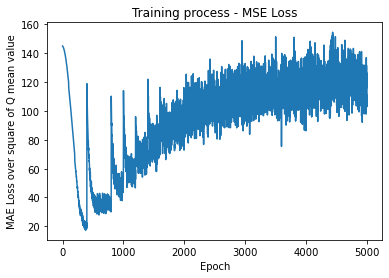

In [4]:
plt.xlabel('Epoch')
plt.ylabel('MAE Loss over square of Q mean value')
plt.title('Training process - MSE Loss')
plt.plot(np.array(mae_liste).reshape((-1)))
plt.show()

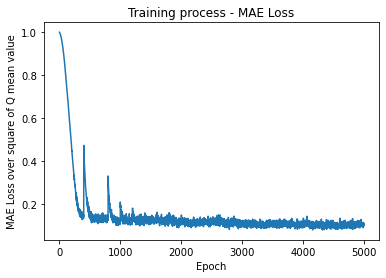

In [11]:
# plt.ylim([0, 0.6])
plt.xlabel('Epoch')
plt.ylabel('MAE Loss over square of Q mean value')
plt.title('Training process - MAE Loss')
plt.plot(-np.array(mae_liste_).reshape((-1)))
plt.show()

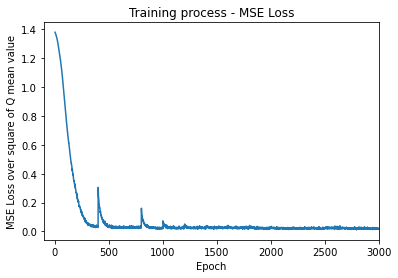

In [13]:
# plt.ylim([0, 0.6])
# plt.figure(figsize = (8, 4))
plt.xlim((-100, 3000))
# plt.ylim((-480, 50))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss over square of Q mean value')
plt.title('Training process - MSE Loss')
plt.plot(np.array(loss_liste).reshape((-1)))
plt.show()

In [24]:
model_test.build((6))

ValueError: Specified input shape is not one of the valid types. Please specify a batch input shape of type tuple or list of input shapes. User provided input type: <class 'int'>

In [19]:
model_test = DQNet()
model_test.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')
model_test.load_weights("./target_model_monday")

In [20]:
for at in range(1, 10):
    action_0 = 0.1 * (-1 + (at - 1)//3)
    action_1 = 0.1 * (-1 + (at - 1) %3)
    print(model_test.call(inputs = tf.constant([[mini[0], mini[1], mini[2], mini[3], action_0, action_1]])).numpy()[0][0])

129.64062
151.50586
173.71365
114.818
135.94897
157.43039
100.44123
120.81562
141.54428


In [50]:
model_test = DQNet()
model_test.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')
model_test.load_weights("./target_model_monday")

In [51]:
for at in range(1, 10):
    action_0 = 0.1 * (-1 + (at - 1)//3)
    action_1 = 0.1 * (-1 + (at - 1) %3)
    print(model_test.call(inputs = tf.constant([[mini[0], mini[1], mini[2], mini[3], action_0, action_1]])).numpy()[0][0])

-639.0664
-627.7097
-616.1621
-633.0902
-621.6746
-610.07104
-627.1056
-615.6318
-603.9721


In [23]:
mini = replay_memory[0]
print(mini)

[351.0, 307.0, 119.0, 537.0, 6.0, -323.88269481403296, 351.0, 311.0]


In [38]:
for at in range(1, 10):
    action_0 = 0.1 * (-1 + (at - 1)//3)
    action_1 = 0.1 * (-1 + (at - 1) %3)
    print(model_.call(inputs = tf.constant([[mini[0], mini[1], mini[2], mini[3], action_0, action_1]])).numpy()[0][0])
print(model_.get_best([mini[0], mini[1]], [mini[2], mini[3]], get_action = True, is_training = True))

-639.0664
-627.7097
-616.1621
-633.0902
-621.6746
-610.07104
-627.1056
-615.6318
-603.9721
9


In [33]:
mini[5], mini[5] + 0.99*(model_.get_best([mini[6], mini[7]], [mini[2], mini[3]], get_action = False, is_training = True))

(-323.88269481403296, -638.1497172139352)

In [17]:
(model_test.get_best([20.0, 510.0], [203.0, 495.0], get_action = False, is_training = True), 
 model_test.get_best([20.0, 510.0], [203.0, 495.0], get_action = True, is_training = True))

(-0.5129102, 9)

In [14]:
for at in range(1, 10):
    action_0 = 0.1 * (-1 + (at - 1)//3)
    action_1 = 0.1 * (-1 + (at - 1) %3)
    print(model_test.call(inputs = tf.constant([[119.0, 537.0, 119.0, 537.0, action_0, action_1]])).numpy()[0][0])
print(model_test.get_best([119.0, 537.0], [119.0, 537.0], get_action = True, is_training = True))

-46.035507
-44.26158
-42.60855
-46.45584
-44.816727
-43.297043
-46.930946
-45.426804
-44.04123
3


In [13]:
replay_memory

[[351.0, 307.0, 119.0, 537.0, 6.0, -323.88269481403296, 351.0, 311.0],
 [351.0, 311.0, 293.0, 374.0, 5.0, -81.39410298049853, 353.0, 319.0],
 [353.0, 319.0, 351.0, 321.0, 3.0, -8.94427190999916, 347.0, 329.0],
 [347.0, 329.0, 343.0, 347.0, 8.0, -14.422205101855956, 351.0, 335.0],
 [351.0, 335.0, 351.0, 309.0, 5.0, -34.0, 351.0, 343.0],
 [351.0, 343.0, 351.0, 364.0, 1.0, -27.0, 351.0, 337.0],
 [351.0, 337.0, 335.0, 407.0, 4.0, -95.35197952848173, 351.0, 313.0],
 [351.0, 313.0, 351.0, 311.0, 9.0, -4.0, 351.0, 307.0],
 [351.0, 307.0, 187.0, 527.0, 6.0, -252.50742563338608, 351.0, 335.0],
 [351.0, 335.0, 119.0, 537.0, 5.0, -302.42354405700627, 351.0, 343.0],
 [351.0, 343.0, 218.0, 570.0, 3.0, -256.2225595063791, 351.0, 351.0],
 [351.0, 351.0, 351.0, 337.0, 6.0, -25.298221281347036, 343.0, 361.0],
 [343.0, 361.0, 100.0, 548.0, 4.0, -306.62354769325856, 343.0, 361.0],
 [343.0, 361.0, 351.0, 345.0, 2.0, -10.198039027185569, 349.0, 355.0],
 [349.0, 355.0, 281.0, 503.0, 7.0, -172.8120366178236,

In [ ]:
# acc = history.history['sparse_categorical_accuracy']
# val_acc = history.history['val_sparse_categorical_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.subplot(1, 2, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

一种新的训练方法

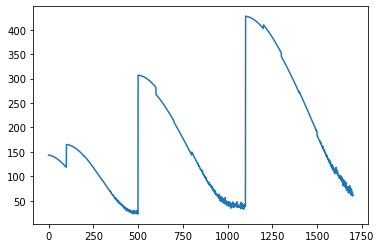

In [13]:
plt.plot(np.array(mae_list).reshape((-1)))